In [1]:
from qiskit_algorithms.utils import algorithm_globals

from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.circuit import ParameterVector

from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN

import time
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt
import numpy as np

from qiskit.circuit import QuantumRegister,ClassicalRegister
from IPython.display import clear_output

from scipy.special import rel_entr
import pickle

In [2]:
def getGradient_pShift(qnn,weights):
    grad=[]
    for i in range(len(weights)):
        weights_plus=weights.copy()
        weights_plus[i]+=np.pi/2
        weights_minus=weights.copy()
        weights_minus[i]-=np.pi/2
        plus=qnn.forward([],weights_plus)
        minus=qnn.forward([],weights_minus)
        grad.append(0.5*(plus-minus))
    return np.array(grad)[:,0,0]

def getHessian_pShift(qnn,weights):
    #grad=[]
    hess=np.zeros([len(weights),len(weights)])
    angle_div=1/4
    angle=np.pi*angle_div
    for i in range(len(weights)):
        for j in np.arange(i,len(weights),1):
            tmpWeights=np.array([weights.copy()]*4)
            tmpWeights[0][i]+=angle
            tmpWeights[0][j]+=angle
            
            tmpWeights[1][i]-=angle
            tmpWeights[1][j]+=angle
            
            tmpWeights[2][i]+=angle
            tmpWeights[2][j]-=angle
        
            tmpWeights[3][i]-=angle
            tmpWeights[3][j]-=angle
            
            plusPlus=qnn.forward([],tmpWeights[0])[0][0]
            minusPlus=qnn.forward([],tmpWeights[1])[0][0]
            plusMinus=qnn.forward([],tmpWeights[2])[0][0]
            minusMinus=qnn.forward([],tmpWeights[3])[0][0]

                
            hess[i][j]=(angle_div*angle_div)*(plusPlus+minusMinus-minusPlus-plusMinus)
            hess[j][i]=(angle_div*angle_div)*(plusPlus+minusMinus-minusPlus-plusMinus)
            #grad.append((angle_div*angle_div)*(plusPlus+minusMinus-minusPlus-plusMinus))
    #hess=np.array(grad)[:,0,0].reshape(len(weights),len(weights))
    return hess
        

In [3]:


def countZero(x):
    out=f"{bin(x)}".count("1")
    if out==0:
        return 0
    else:
        return 1
    #return f"{bin(x)}".count("1")%n_qubits

In [4]:
def make_ansatz(qc_ansatz,num_layers,num_qubits,weights):
    #rest layers
    params_index = 0 #index counter
    for layer in range(num_layers):
        
            
        #X, Y and Z interaction
        
        for i in range(num_qubits):
            qc_ansatz.ry(weights[params_index],i)
            params_index += 1
        for i in range(num_qubits-1):
            qc_ansatz.cx(i,i+1)
#         for i in range(n_qubits):
#                 qc.rz(weights[params_index],i)
#                 params_index += 1
               
    return qc_ansatz
def make_ansatz_unitary(num_layers,num_qubits,params):
    qr = QuantumRegister(num_qubits,'qr') #quantum register
    cr = ClassicalRegister(num_qubits,'cr') #classical register
    qc = QuantumCircuit(qr,cr) #construct ansatz
    qc=make_ansatz(qc,num_layers,num_qubits,params)
    qc.draw('mpl')
    return qi.Operator(qc)


def mkSampler(U_target):
    inputs = ParameterVector("input", 0)
    weights = ParameterVector("weight", n_params)
    #print(f"input parameters: {[str(item) for item in inputs.params]}")
    #print(f"weight parameters: {[str(item) for item in weights.params]}")
    params_index=0
    qc = QuantumCircuit(2*n_qubits)
    qr=qc.qubits
    A = [qr[i] for i in range(n_qubits)]
    B = [qr[i] for i in range(n_qubits,n_qubits*2)]


    qc.h(A)
    qc.barrier()
    qc.cx(A,B)
    qc.barrier()
    for layer in range(n_layers):        
            for i in range(n_qubits):
                qc.ry(weights[params_index],i)
                params_index += 1
            for i in range(n_qubits-1):
                qc.cx(i,i+1)
                
#             for i in range(n_qubits):
#                 qc.rz(weights[params_index],i)
#                 params_index += 1
                
                
    qc.unitary(U_target.conjugate(),qubits=B, label='$U_{target}^{*}$')
    qc.barrier()
    qc.cx(A,B)
    qc.barrier()
    qc.h(A)
    qc.barrier()
    sampler_qnn = SamplerQNN(circuit=qc,input_params=inputs, weight_params=weights,
                         interpret=countZero,output_shape=2
                        )
    return qc,sampler_qnn
    
    
    
def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x)
    plt.show()

In [32]:
n_qubits=4
dims=2**n_qubits
n_layers=60
n_params=n_qubits*n_layers
#shots = 1000
#sampler = Sampler(options={"shots": shots})

zeroState = '0'
for i in range(n_qubits-1):
    zeroState+='0'

In [63]:
targetParams=np.random.rand(n_params)*np.pi*2
U_target=make_ansatz_unitary(num_qubits=n_qubits,num_layers=n_layers,params=targetParams)
#U_target=qi.random_unitary(dims)
U_target=np.array(U_target)

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


In [64]:
qr = QuantumRegister(n_qubits,'qr') #quantum register
cr = ClassicalRegister(n_qubits,'cr') #classical register
qc = QuantumCircuit(qr,cr) #construct ansatz
qc=make_ansatz(qc,n_layers,n_qubits,targetParams)

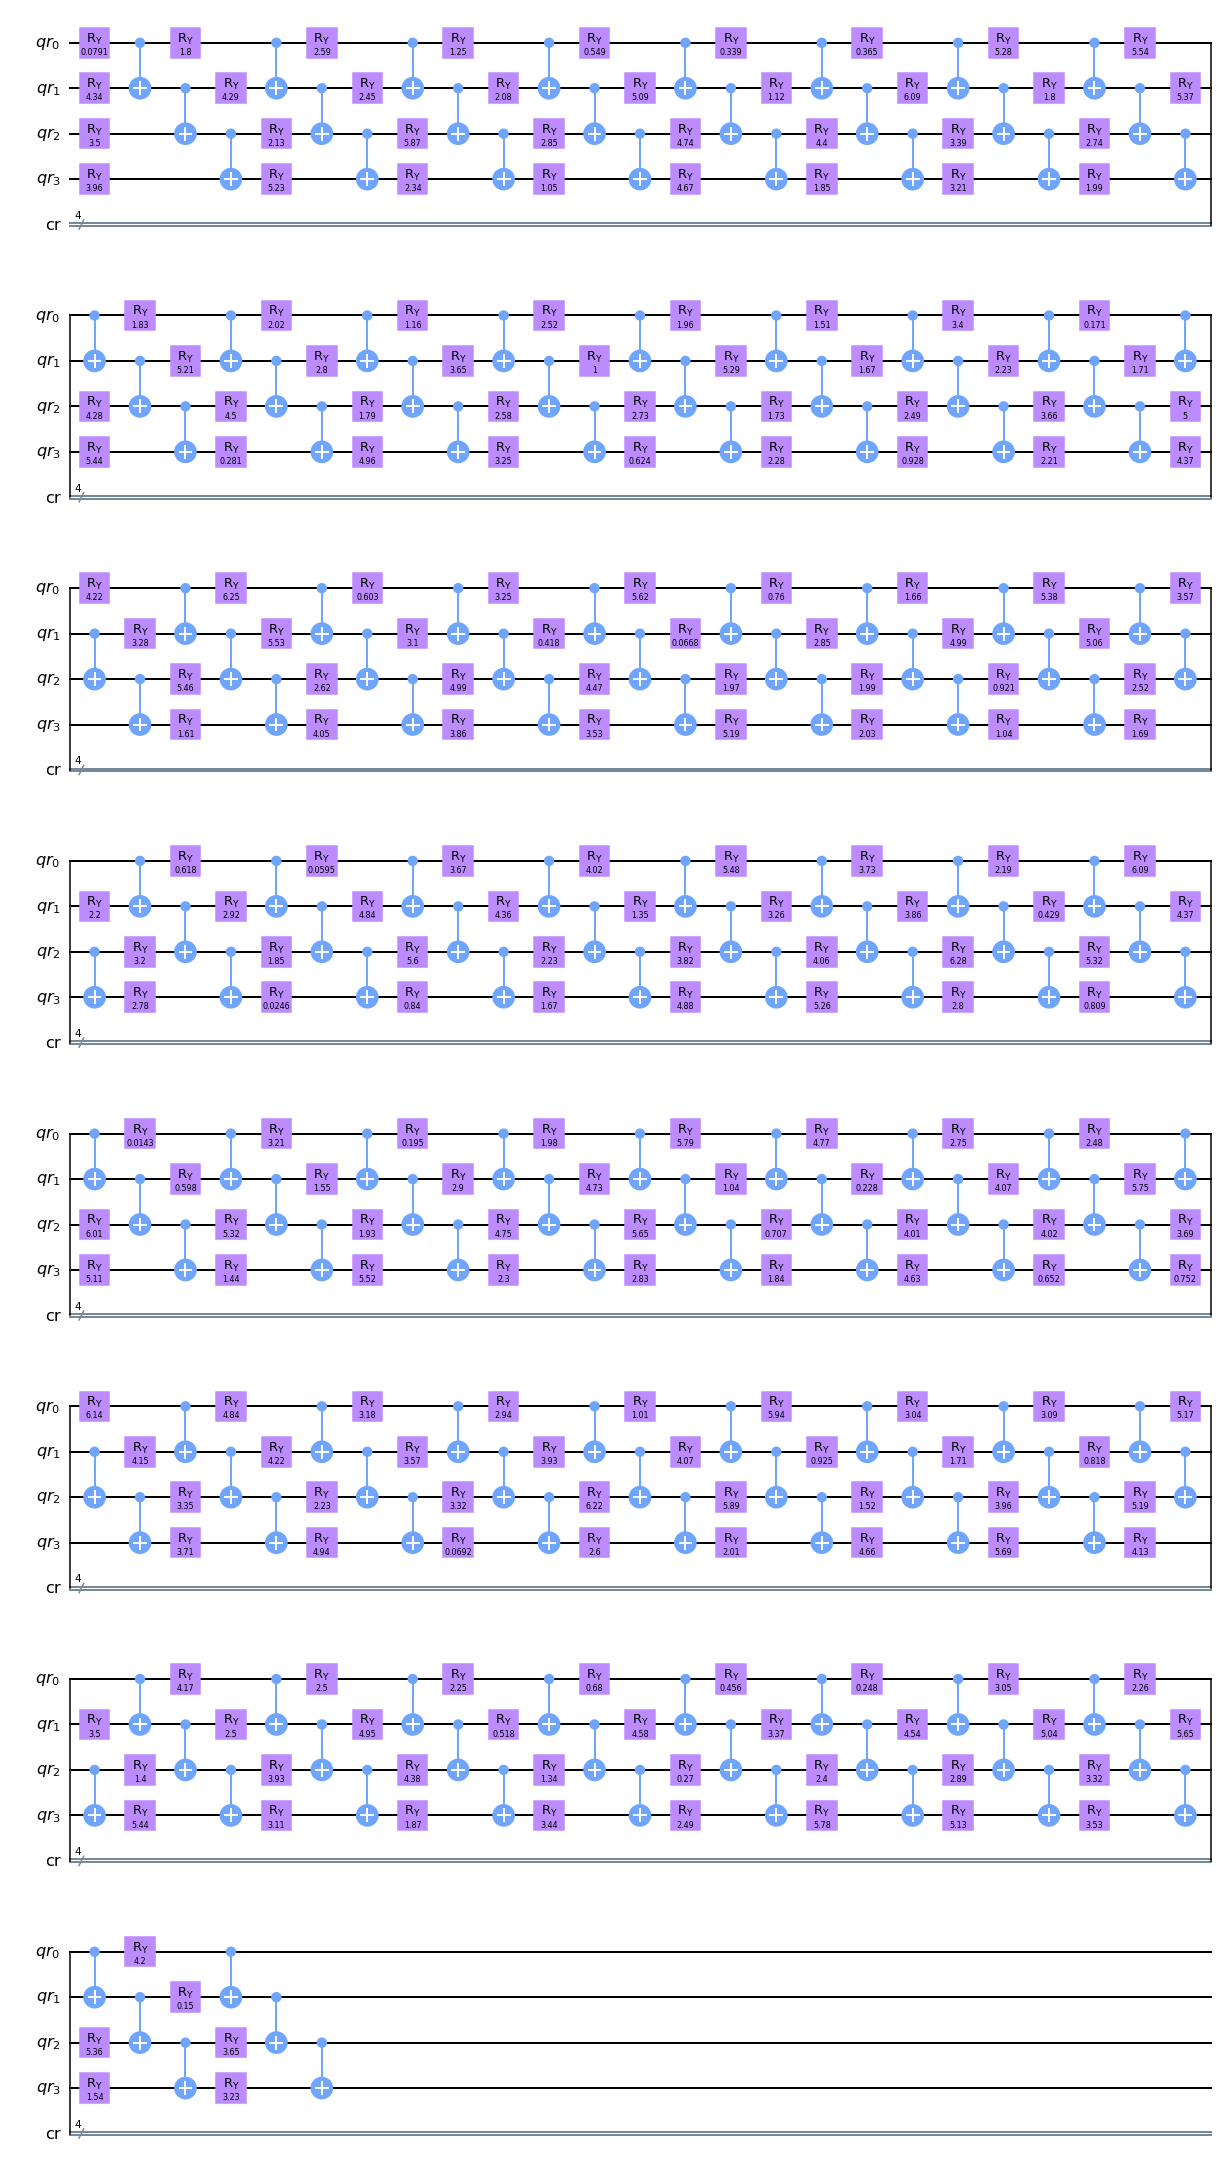

In [35]:
qc.draw('mpl')

In [65]:
qc,sampler=mkSampler(U_target)

In [66]:
qc.num_parameters

240

In [67]:
def train(sampler,weights,learning_rate=1e-2,inputs=[]):
    out=sampler.forward(inputs, weights)
    input_grad,weight_grad = sampler.backward(inputs, weights)
    grad=weight_grad[0][0] 
    weights+=learning_rate*grad
    
    cost=out[0][1]
    gradMag= np.sqrt((grad**2).sum())
    
    return cost, weights,grad,gradMag

In [79]:
def getMag(x):
    x2=x**2
    return np.sqrt(x2.sum())

def getI(cx,cy,x,y):
    cos=(x*y).sum()/(getMag(x)*getMag(y))
    return (1-cos)

In [70]:
sampler_input = np.array([])
sampler_weights = algorithm_globals.random.random(sampler.num_weights)


In [71]:
sampler.forward(sampler_input,sampler_weights)

array([[0.02173797, 0.97826203]])

In [72]:
t1=time.time()
a,b=sampler.backward(sampler_input,sampler_weights)
print(time.time()-t1)

6.512737035751343


my algorithm

In [195]:
def myAlg(sampler,nSteps=100,learning_rate=1e-2,low=1e-2,high=1e-1,alpha=0.25,
                  threshold=1e-5):
    sampler_input = np.array([])
    sampler_weights = algorithm_globals.random.random(sampler.num_weights)
    List={"cost":[],"rate":[],"grad":[],"I":[0]}
    
    for i in range(nSteps):
        if i%5==0:
            print(i)
        t1=time.time()
        cost, sampler_weights,grad,gradMag=train(sampler,sampler_weights,learning_rate=learning_rate)

        List['cost'].append(cost)
        List['grad'].append(grad)

        if i>1:
            I=getI(cost,List['cost'][-2],grad,List['grad'][-2])
            List['I'].append(I)
            if cost>0.1:
                if I<low:
                    learning_rate=learning_rate*(1+alpha)

                if I>high:
                    learning_rate=learning_rate*(1-alpha)
            else:
              
                if I<low:
                    learning_rate=learning_rate*(1+0.1*alpha)

                if I>high:
                    learning_rate=learning_rate*(1-0.1*alpha)
        List['rate'].append(learning_rate)
        if cost<1e-5:
            break
        if i%20==0:

            clear_output(wait=True)
            plt.figure(1)
            plt.yscale('log')
            callback_graph(List['cost'])
            plt.figure(2)
            plt.yscale('log')
            callback_graph(List['rate'],"learning rate")
            plt.figure(3)
            plt.yscale('log')
            callback_graph(List['I'],"I value")

        #print(time.time()-t1)

    return List

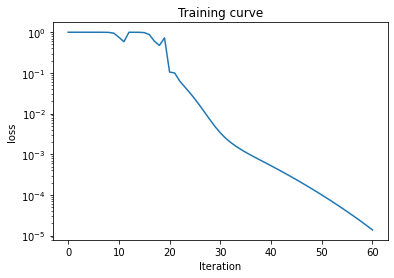

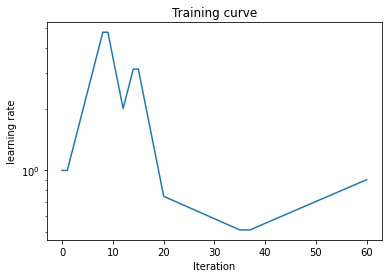

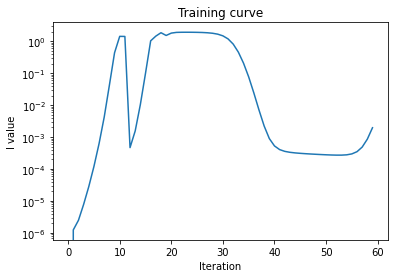

In [196]:
myAlg_1e0=myAlg(sampler,nSteps=200,learning_rate=1e0)

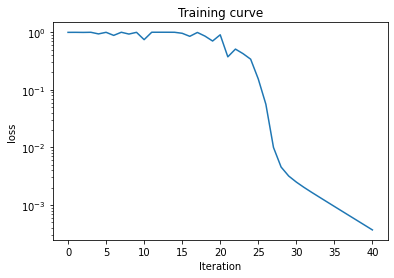

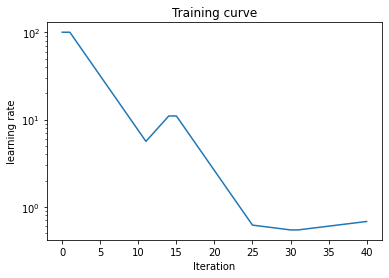

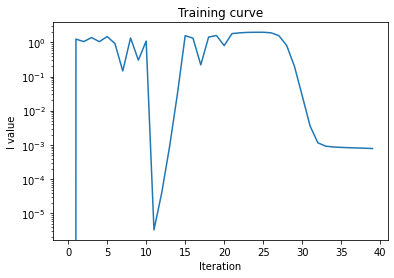

45
50
55


In [197]:
myAlg_1e2=myAlg(sampler,nSteps=200,learning_rate=1e2)

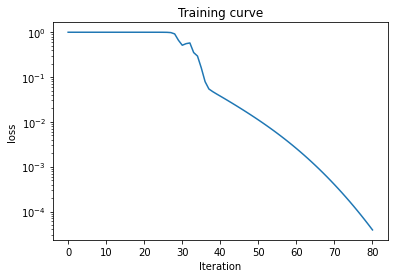

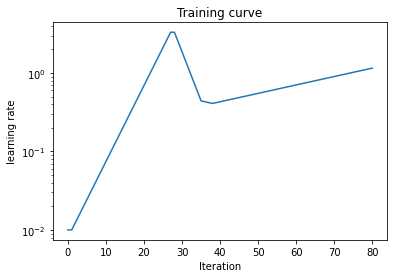

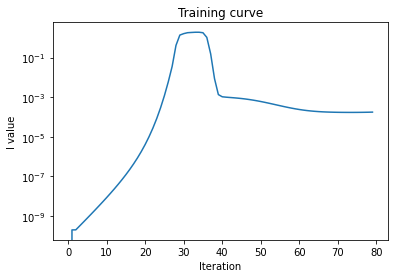

85


In [198]:
myAlg_1en2=myAlg(sampler,nSteps=200,learning_rate=1e-2)

In [199]:

with open("Mine_1e2.pk", "wb") as fp:   #Pickling
    
    pickle.dump(myAlg_1e2, fp)
    
with open("Mine_1e0.pk", "wb") as fp:   #Pickling
    
    pickle.dump(myAlg_1e0, fp)
    
with open("Mine_1en2.pk", "wb") as fp:   #Pickling
    
    pickle.dump(myAlg_1en2, fp)

<Figure size 432x288 with 0 Axes>

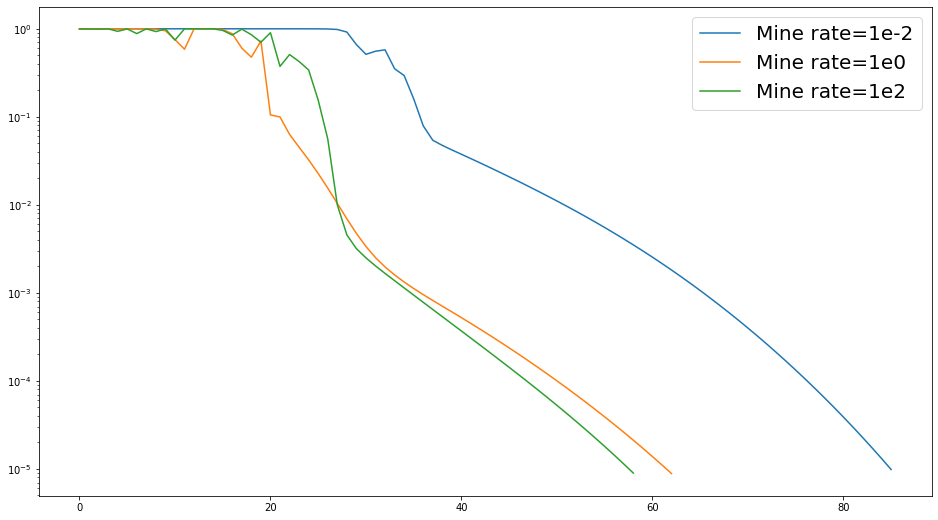

In [200]:
plt.figure(1)
plt.figure(figsize=(16,9))
plt.yscale('log')
plt.plot(range(len(myAlg_1en2['cost'])),myAlg_1en2['cost'],label="Mine rate=1e-2")
plt.plot(range(len(myAlg_1e0['cost'])),myAlg_1e0['cost'],label="Mine rate=1e0")
plt.plot(range(len(myAlg_1e2['cost'])),myAlg_1e2['cost'],label="Mine rate=1e2")
plt.legend(fontsize=20)

COBYLA

In [ ]:
import scipy.optimize 

def cost(params, sampler):
    """
    input: 
        params: list of parameters
        num_qubit: number of qubits
        num_layers: number of layers
        
    output: value of cost function (VEV of Hamiltonian)
    
    global variables:
        cost_val_list: list of cost function values
    """
    global cost_val_list

    
    cost=sampler.forward(sampler_input,params)[0][1]
    cost_val_list.append(cost)
    
    
    return cost

method="COBYLA" 
nMaxIter=5000
global cost_val_list 
cost_val_list = [] #clear list for cost function values
  
init = algorithm_globals.random.random(sampler.num_weights) #parameter initialization
res = scipy.optimize.minimize(cost, init,method=method,args=( sampler),options={'maxiter':nMaxIter}) #minimize cost function via scipy
cost_val_list_COBYLA=cost_val_list
plt.yscale('log')
plt.plot(range(nMaxIter),cost_val_list_COBYLA)

LBFGS via pyTorch

In [157]:
import torch
from torch.autograd import Variable
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
from qiskit_machine_learning.connectors import TorchConnector
from torch.optim import Adam

In [209]:
def train_LBFGS_pytorch(sampler,lr=1e-1,max_iter=300):
    init = algorithm_globals.random.random(sampler.num_weights)
    sampler_torch = TorchConnector(sampler, initial_weights=init)
    optimizer = LBFGS(sampler_torch.parameters(),lr=lr, max_iter=max_iter)
    f_loss = CrossEntropyLoss()  
    X=Tensor(sampler_input)
    y=Tensor(np.array([1,0]))
    print(sampler.forward(sampler_input,init))
    
    # Start training
    sampler_torch.train()
    global costList
    costList=[]
    # Define LBFGS closure method (explained in previous section)
    def closure():
        global costList
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        loss = f_loss(sampler_torch(X), y)  # Calculate loss
        loss.backward()  # Backward pass

        for param in sampler_torch.parameters():
            w=param.detach().numpy()
        cost=sampler.forward(sampler_input,w)[0][1]
        costList.append(cost)
        if(len(costList)%20==0):
            print(cost)

        return loss

    # Run optimizer (LBFGS requires closure)
    optimizer.step(closure);
        
    return costList
    

In [210]:
t1=time.time()
cost_list_LBFGStorch_1e2=train_LBFGS_pytorch(sampler,lr=1e02,max_iter=100)
print(time.time()-t1)

[[0.00783741 0.99216259]]
99.40772294998169


In [211]:
cost_list_LBFGStorch_1e2

[0.9921625873251463,
 0.9970381960718223,
 0.9898867616923797,
 0.9989687340835651,
 0.9959408131848735,
 0.9998143216891201,
 0.9991124417962357,
 0.9999027614816817,
 0.999232754693375,
 0.9991331561946514,
 0.9981160520347206,
 0.9939456981636887,
 0.9960371126388368,
 0.9986901328556111,
 0.9969713972310793]

In [126]:
cost_list_LBFGStorch_1e0=[]
t1=time.time()
cost_list_LBFGStorch_1e0=train_LBFGS_pytorch(sampler,lr=1e0,max_iter=100)
print(time.time()-t1)

[[8.02086643e-04 9.99197913e-01]]
0.6537565030487152
0.9510037951871665
0.13853553025237775
1.6012601889999996e-07
542.5929388999939


In [143]:
t1=time.time()
cost_list_LBFGStorch_1en2=train_LBFGS_pytorch(sampler,lr=1e-2,max_iter=100)
print(time.time()-t1)

[[0.0052704 0.9947296]]
0.9926032951039591
0.9893948326389506
0.9848547107586373
0.9784906691074688
0.9696857710256485
1520.8159368038177


In [151]:
cost_LBFGS={"1e0":cost_list_LBFGStorch_1e0,"1e2":cost_list_LBFGStorch_1e2,"1en2":cost_list_LBFGStorch_1en2}

In [152]:

with open("LBFGS.pk", "wb") as fp:   #Pickling
    
    pickle.dump(cost_LBFGS, fp)
    


In [183]:
def train_ADAM_pytorch(sampler,lr=1e-1,max_iter=100):
    init = algorithm_globals.random.random(sampler.num_weights)
    sampler_torch = TorchConnector(sampler, initial_weights=init)
    optimizer = Adam(sampler_torch.parameters(),lr=lr)
    f_loss = CrossEntropyLoss()  
    X=Tensor(sampler_input)
    y=Tensor(np.array([1,0]))

    
    # Start training
    sampler_torch.train()
    global costList
    costList=[]

    for i in range(max_iter):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        loss = f_loss(sampler_torch(X), y)  # Calculate loss
        loss.backward()  # Backward pass

        for param in sampler_torch.parameters():
            w=param.detach().numpy()
        cost=sampler.forward(sampler_input,w)[0][1]
        costList.append(cost)
        print(cost)
        optimizer.step();
        if cost<1e-5:
            break

    return costList
    

In [203]:
t1=time.time()
cost_list_ADAMtorch_1en1=train_ADAM_pytorch(sampler,lr=1e-1)
print(time.time()-t1)

0.9991363544054296
0.8946781372823754
0.7111893840076088
0.6129597858767424
0.5717354989329977
0.547904599609542
0.5242597545522747
0.5099838057001479
0.505520908309624
0.5060536248653251
0.495397085760442
0.4685385146949933
0.41870713667122156
0.34570425555033996
0.2577198361596125
0.18633617971258118
0.14769568220821472
0.12453834333932783
0.11896290763636017
0.12634881974904216
0.12362921098499789
0.1072861962912939
0.08997024792150493
0.07199506711838631
0.05419959494842597
0.04737651172837947
0.049998422495674086
0.050061680905091596
0.04635849516569241
0.04302832642941964
0.03889921986327517
0.033019815891658096
0.0280682882462266
0.02510128154387609
0.023393879601261804
0.02195225361176981
0.018989060066698406
0.015848021386611604
0.015423317284532792
0.0156589353302745
0.014084939725602796
0.012502714652203395
0.011615067481105695
0.009878531599222598
0.008104865802326902
0.0077951790370458995
0.0078323594451423
0.0067142100189398
0.004776309393575101
0.0038482593883860995
0.00

In [187]:
t1=time.time()
cost_list_ADAMtorch_1en2=train_ADAM_pytorch(sampler,lr=1e-2)
print(time.time()-t1)

0.9953768850196598
0.983745376058941
0.9658933978819361
0.9423313161988202
0.9136722086169091
0.8808449754345535
0.8450486535291633
0.8074166484188242
0.7689122844539364
0.7302757200622776
0.6920294704768057
0.6544924213459018
0.6179225327220413
0.5826379343509145
0.5490153151100411
0.5174045565100693
0.4880149159394467
0.4608680213519355
0.43581318276581144
0.41258011315046517
0.3908375567685671
0.37022884461173255
0.35038774836027287
0.33095420508084583
0.31159513558315743
0.2920277302061493
0.27204825103052543
0.2515656757270201
0.23063200502673223
0.2094542986862499
0.18837585118632136
0.1678298245176528
0.14827662251414075
0.13013708106270488
0.11373485288011594
0.099259176791265
0.08675182359248572
0.07611596019338435
0.06714305621782667
0.0595533108003705
0.053043759878227244
0.04733558485645629
0.04221151547034908
0.037535641268586876
0.033252871173104395
0.029370665185823104
0.025930180766643218
0.022975438195480116
0.02052825293508831
0.0185738519980731
0.017058664470087703
0

In [219]:
t1=time.time()
cost_list_ADAMtorch_1e0=train_ADAM_pytorch(sampler,lr=1e0)
print(time.time()-t1)

0.9946670601629128
0.9955604957022598
0.9999371361633462
0.9994925160164958
0.9980077623741114
0.9995932058224318
0.9998412721933554
0.9999907289278659
0.998619266262703
0.9617402739187003
0.9991174768021515
0.9871980362592939
0.9989051339223002
0.9958068740535718
0.9983481833924688
0.9932423020738418
0.9962338494354313
0.990255585240385
0.997422830012091
0.9974852589302454
0.9955055066915235
0.9585377916460417
0.9834162461226854
0.990536987371201
0.9923101211667781
0.9919102262922248
0.9682176213034777
0.9867715797568356
0.9941245958131696
0.9556504957183389
0.9784653050365409
0.9888545700612512
0.9801452239299798
0.9664564566951414
0.9749411182282557
0.9511160248995332
0.9896844087008659
0.9990764126694606
0.9979867564044987
0.9837538825535052
0.8958441296765671
0.9976675074134678
0.99717922094245
0.9971503580771452
0.9908061964728201
0.9381775065182071
0.9987305585323868
0.9840980945260803
0.9842024598586012
0.932762484447769
0.9952215621887929
0.9682130790529964
0.966316708580602
0

In [233]:
color={'0':'r','2':'g','n2':'b'}

<Figure size 432x288 with 0 Axes>

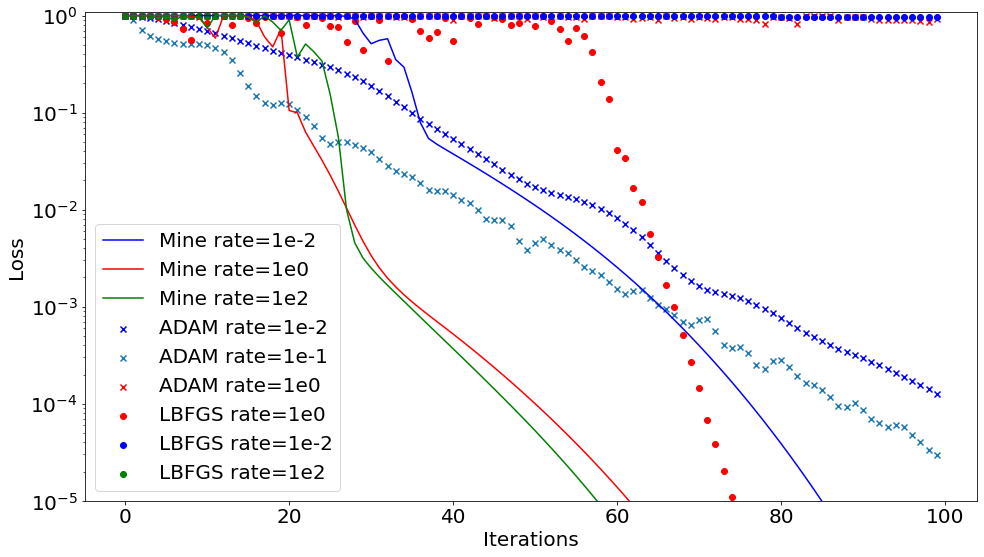

In [236]:
LabelSize=20
plt.figure(1)
plt.figure(figsize=(16,9))
plt.yscale('log')
plt.ylim(1e-5,1.1)
plt.plot(range(len(myAlg_1en2['cost'])),myAlg_1en2['cost'],color=color['n2'],label="Mine rate=1e-2")
plt.plot(range(len(myAlg_1e0['cost'])),myAlg_1e0['cost'],color=color['0'],label="Mine rate=1e0")
plt.plot(range(len(myAlg_1e2['cost'])),myAlg_1e2['cost'],color=color['2'],label="Mine rate=1e2")
plt.scatter(range(len(cost_list_ADAMtorch_1en2)),cost_list_ADAMtorch_1en2,color=color['n2'],marker='x',label="ADAM rate=1e-2")
plt.scatter(range(len(cost_list_ADAMtorch_1en1)),cost_list_ADAMtorch_1en1,marker='x',label="ADAM rate=1e-1")
plt.scatter(range(len(cost_list_ADAMtorch_1e0)),cost_list_ADAMtorch_1e0,color=color['0'],marker='x',label="ADAM rate=1e0")
plt.scatter(range(len(cost_list_LBFGStorch_1e0)),cost_list_LBFGStorch_1e0,color=color['0'],label="LBFGS rate=1e0")
plt.scatter(range(len(cost_list_LBFGStorch_1en2)),cost_list_LBFGStorch_1en2,color=color['n2'],label="LBFGS rate=1e-2")
plt.scatter(range(len(cost_list_LBFGStorch_1e2)),cost_list_LBFGStorch_1e2,color=color['2'],label="LBFGS rate=1e2")
plt.xlabel('Iterations',fontsize=LabelSize)
plt.ylabel('Loss',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)
plt.savefig("training_algorithm_comparison")

<Figure size 432x288 with 0 Axes>

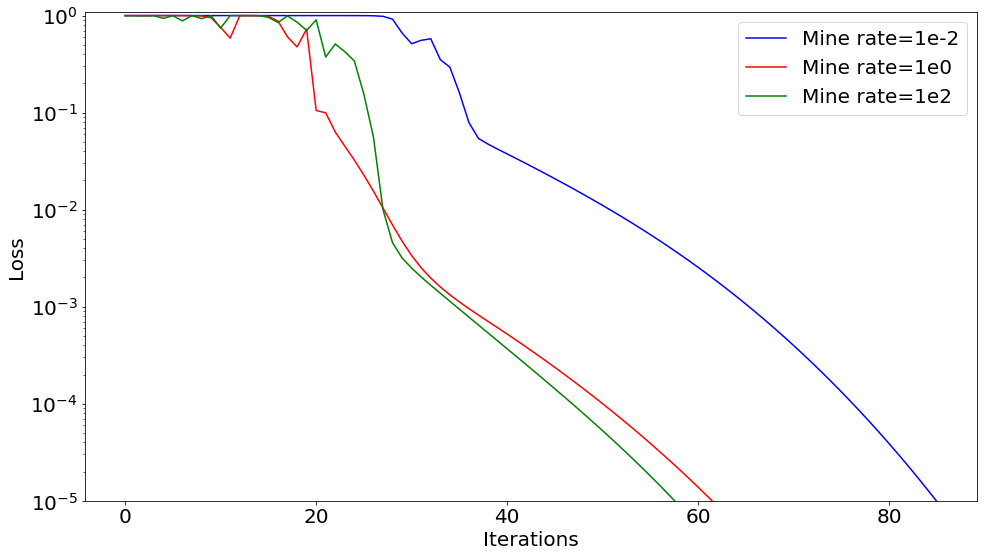

In [237]:
LabelSize=20
plt.figure(1)
plt.figure(figsize=(16,9))
plt.yscale('log')
plt.ylim(1e-5,1.1)
plt.plot(range(len(myAlg_1en2['cost'])),myAlg_1en2['cost'],color=color['n2'],label="Mine rate=1e-2")
plt.plot(range(len(myAlg_1e0['cost'])),myAlg_1e0['cost'],color=color['0'],label="Mine rate=1e0")
plt.plot(range(len(myAlg_1e2['cost'])),myAlg_1e2['cost'],color=color['2'],label="Mine rate=1e2")
plt.xlabel('Iterations',fontsize=LabelSize)
plt.ylabel('Loss',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)
plt.savefig("training_algorithm_mine")

<Figure size 432x288 with 0 Axes>

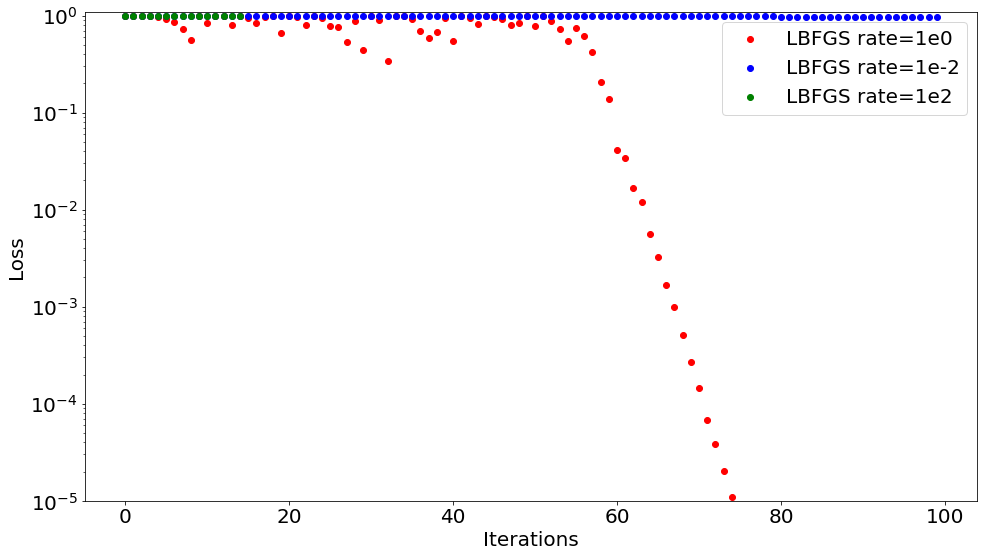

In [238]:
LabelSize=20
plt.figure(1)
plt.figure(figsize=(16,9))
plt.yscale('log')
plt.ylim(1e-5,1.1)
plt.scatter(range(len(cost_list_LBFGStorch_1e0)),cost_list_LBFGStorch_1e0,color=color['0'],label="LBFGS rate=1e0")
plt.scatter(range(len(cost_list_LBFGStorch_1en2)),cost_list_LBFGStorch_1en2,color=color['n2'],label="LBFGS rate=1e-2")
plt.scatter(range(len(cost_list_LBFGStorch_1e2)),cost_list_LBFGStorch_1e2,color=color['2'],label="LBFGS rate=1e2")
plt.xlabel('Iterations',fontsize=LabelSize)
plt.ylabel('Loss',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)
plt.savefig("training_algorithm_LBFGS")

<Figure size 432x288 with 0 Axes>

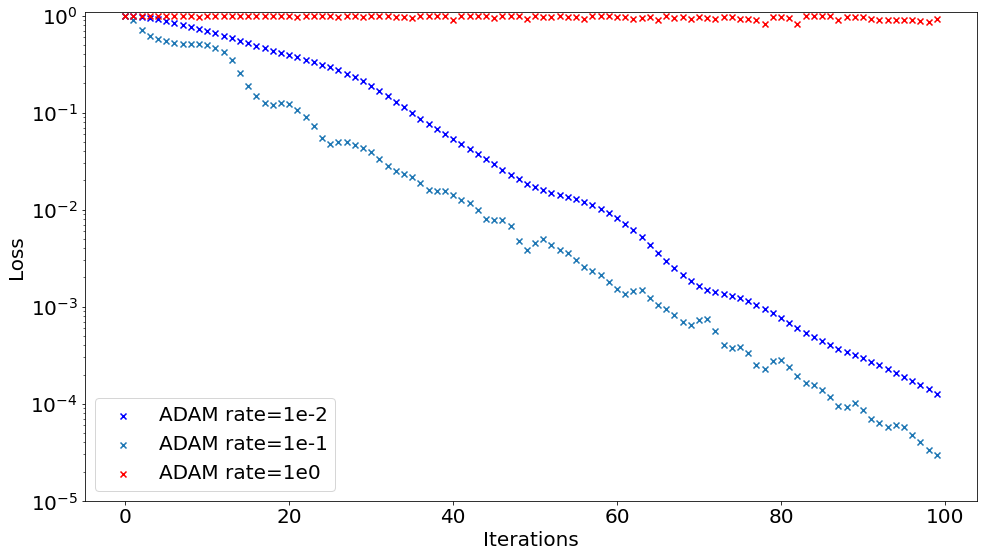

In [239]:
LabelSize=20
plt.figure(1)
plt.figure(figsize=(16,9))
plt.yscale('log')
plt.ylim(1e-5,1.1)
plt.scatter(range(len(cost_list_ADAMtorch_1en2)),cost_list_ADAMtorch_1en2,color=color['n2'],marker='x',label="ADAM rate=1e-2")
plt.scatter(range(len(cost_list_ADAMtorch_1en1)),cost_list_ADAMtorch_1en1,marker='x',label="ADAM rate=1e-1")
plt.scatter(range(len(cost_list_ADAMtorch_1e0)),cost_list_ADAMtorch_1e0,color=color['0'],marker='x',label="ADAM rate=1e0")
plt.xlabel('Iterations',fontsize=LabelSize)
plt.ylabel('Loss',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)
plt.savefig("training_algorithm_ADAM")